<div style="text-align: center;">
<img src="https://assets-global.website-files.com/62b9d45fb3f64842a96c9686/62d84db4aeb2f6552f3a2f78_Quantinuum%20Logo__horizontal%20blue.svg" width="200" height="200" /></div>


# High Energy Physics: Implementing $SU(2)$ Lattice Gauge Theory Trotter Circuits on Quantinuum H-Series quantum computers with TKET

Quantum computers have the ability to tackle problems beyond the reach of classical systems. One such application lies in the realm of quantum field theories, where lattice gauge theories provide a rigorous framework to derive non-perturbative results. Before diving in, you may find it helpful to review the [Definitions](#Definitions) at the end of this article if you're unfamiliar with high energy physics.

## Introduction

Lattice gauge theory (LGT) is a vital computational tool in quantum field theory, enabling the acquisition of rigorous results without relying on perturbation theory. It's particularly significant in the context of quantum chromodynamics (QCD), where lattice computations have been instrumental in uncovering new properties of known hadrons, evaluating the likelihood of undiscovered hadrons, and providing critical insights for the search for new physics beyond the standard model.

Typically, LGT studies are conducted in Euclidean spacetime, where time is treated as an imaginary component. This approach is effective for many observables, but it limits the ability to analyze real-time dynamics. However, a Hamiltonian formulation in real-time could overcome this limitation, given adequate computing resources. This is where the potential of future quantum computers becomes particularly intriguing. Quantum computers could handle and evolve quantum states far beyond the capabilities of classical computers, thus offering a promising avenue for exploring real-time dynamics within LGT.

The paper [Self-mitigating Trotter circuits for SU(2) lattice gauge theory on a quantum computer](http://arxiv.org/abs/2205.09247) by Rahman, Lewis, Mendicelli, and Powell delves into the implementation of SU(2) lattice gauge theory in Minkowski spacetime using quantum computers, showcasing the real-time evolution of excitations across a lattice. While the theoretical foundations laid out in the paper are robust, practical implementation on contemporary quantum hardware requires specialized techniques and considerations. 

This knowledge article, complete with detailed code, explores the implementation of methods described in this paper on the Quantinuum H-Series devices. Utilizing TKET, we detail the process of defining the SU(2) 2-Plaquette (two-qubit) Model Hamiltonian, setting up quantum circuits, and employing Trotterization to simulate the quantum dynamics of the system. For a single Trotter step, we simulate the ideal execution of a quantum circuit using a statevector simulator. The two Trotter step case is executed on the Quantinuum H1-2 emulator, and we also demonstrate an example of symbolic circuit construction for these circuits. The final section details the implementation of the SU(2) 5-Plaquette (five-qubit) Model Hamiltonian using the `Qiskit` library.

## Setup

This notebook was generated using `pytket=1.23.0`, `pytket-quantinuum=0.26.0`, and `pytket-qiskit=0.47.0`. 

First, we import the libraries and modules we will use:

 - `Pauli` utilities and `QubitPauliOperator` are used for Hamiltonian representation.
 - `Circuit` utilities from `pytket` are used for constructing and analyzing quantum circuits.
 - Additional utilities are used for generating term sequences and gate statistics.
 - Standard libraries are used for numerical operations and visualization.

In [1]:
from pytket.pauli import Pauli, QubitPauliString
from pytket.utils import QubitPauliOperator
from pytket.circuit import Circuit, Qubit, CircBox
from pytket.utils import gen_term_sequence_circuit
from pytket.utils.stats import gate_counts
from pytket import OpType
import numpy as np
from scipy.linalg import expm
import matplotlib.pyplot as plt

In [4]:
%pip show pytket pytket-quantinuum pytket-qiskit

Name: pytket
Version: 1.23.0
Summary: Python module for interfacing with the CQC tket library of quantum software
Home-page: 
Author: TKET development team
Author-email: tket-support@cambridgequantum.com
License: Apache 2
Location: /Users/erinaldi/mambaforge/envs/pytket/lib/python3.11/site-packages
Requires: graphviz, jinja2, lark-parser, networkx, numpy, qwasm, scipy, sympy, types-pkg-resources, typing-extensions
Required-by: pytket-offline-display, pytket-qiskit, pytket-quantinuum, pytket-qujax, pytket-qulacs
---
Name: pytket-quantinuum
Version: 0.26.0
Summary: Extension for pytket, providing access to Quantinuum backends
Home-page: 
Author: TKET development team
Author-email: tket-support@quantinuum.com
License: Apache 2
Location: /Users/erinaldi/mambaforge/envs/pytket/lib/python3.11/site-packages
Requires: msal, nest-asyncio, pyjwt, pytket, requests, types-requests, websockets
Required-by: 
---
Name: pytket-qiskit
Version: 0.47.0
Summary: Extension for pytket, providing translation

*Note:* Plotting circuits requires an internet connection. An alternative for displaying circuits is the `pytket-offline-display` package for rendering circuits offline with no internet connection, for details see [here](https://github.com/CQCL/pytket-offline-renderer).

## Hamiltonian Formulation 

In quantum mechanics, the Hamiltonian operator plays a pivotal role as it represents the total energy of a system and governs how quantum states evolve with time. The time evolution of a quantum state, denoted as $|ψ(t)⟩$, is described by the Schrödinger equation:

$$
i \hbar \frac{{d|\psi(t)\rangle}}{{dt}} = \hat{H}|\psi(t)\rangle
$$

where $i$ stands for the imaginary unit, $\hbar$ denotes the reduced Planck constant, and $\hat{H}$ signifies the Hamiltonian operator of the system. In the realm of quantum simulations, particularly those involving lattice gauge theories, the Hamiltonian is indispensable. It not only elucidates the system's dynamics but also forms the foundation for creating quantum circuits that simulate this evolution.

## SU(2) 2-Plaquette Model Hamiltonian

The SU(2) 2-plaquette model offers a streamlined representation of lattice gauge theories. The associated Hamiltonian for this model encapsulates the core dynamics of the system, making it apt for simulation on quantum hardware. The Hamiltonian's general expression is:

$$
\hat{H} = \sum_{i,j} J_{ij} \sigma_i^a \sigma_j^a + \sum_i h_i \sigma_i^z
$$

where $J_{ij}$ represents interaction coefficients between lattice sites $i$ and $j$, $\sigma_i^a$ and $\sigma_j^a$ are the Pauli matrices for site $i$ or $j$, with $a$ taking values $x$, $y$ or $z$, and $h_i$ are the external field terms for site $i$.

Here we show the 2-qubit Hamiltonian for the SU(2) 2-plaquette model:

$$
\begin{aligned}
\frac{2}{g^2} H=\left(\begin{array}{cccc}
0 & -2 x & -2 x & 0 \\
-2 x & 3 & 0 & -x \\
-2 x & 0 & 3 & -x \\
0 & -x & -x & \frac{9}{2}
\end{array}\right)= & \frac{3}{8}\left(7 I_0 \otimes I_1-3 Z_0 \otimes I_1-Z_0 \otimes Z_1-3 I_0 \otimes Z_1\right) \\
& -\frac{x}{2}\left(3 X_0 \otimes I_1+X_0 \otimes Z_1\right)-\frac{x}{2}\left(3 I_0 \otimes X_1+Z_0 \otimes X_1\right)
\end{aligned}
$$

- The matrix form represents the action of the Hamiltonian on a 2-qubit system.
- The expanded form shows the Hamiltonian in terms of tensor products of Pauli matrices, providing insight into the system's dynamics and interactions.

This Hamiltonian encapsulates the dynamics of the system and serves as the foundation for subsequent quantum simulations. Specifically, the terms associated with Pauli $Z$ matrices, like $Z_0$ and $Z_1$, capture the on-site energies and interactions between the qubits. The terms involving the Pauli $X$ matrices, such as $X_0$ and $X_1$, represent the interactions influenced by external fields parameterized by $x$. This Hamiltonian provides a framework for analyzing and simulating the dynamics of the SU(2) 2-plaquette model, making it a cornerstone for the quantum simulations presented in the paper and this notebook.

## Implementation of the SU(2) 2-Plaquette Model Hamiltonian

The Hamiltonian for the SU(2) 2-plaquette model is implemented in `pytket` in this notebook using the `QubitPauliOperator` to write the operator on qubits and `QubitPauliString` to represent the individual Pauli string terms. Here we use $x = 2$.

In [5]:
hamiltonian = QubitPauliOperator(
    {
        QubitPauliString([], []): +7 * 3 / 8,
        QubitPauliString([Qubit(0)], [Pauli.Z]): -3 * 3 / 8,
        QubitPauliString([Qubit(0), Qubit(1)], [Pauli.Z, Pauli.Z]): -3 / 8,
        QubitPauliString([Qubit(1)], [Pauli.Z]): -3 * 3 / 8,
        QubitPauliString([Qubit(0)], [Pauli.X]): -3,
        QubitPauliString([Qubit(0), Qubit(1)], [Pauli.X, Pauli.Z]): -1,
        QubitPauliString([Qubit(1)], [Pauli.X]): -3,
        QubitPauliString([Qubit(0), Qubit(1)], [Pauli.Z, Pauli.X]): -1,
    }
)

We can display the `QubitPauliOperator` representation of the Hamiltonian:

In [6]:
print(hamiltonian)

{(): 2.62500000000000, (Zq[0]): -1.12500000000000, (Zq[0], Zq[1]): -0.375000000000000, (Zq[1]): -1.12500000000000, (Xq[0]): -3, (Xq[0], Zq[1]): -1, (Xq[1]): -3, (Zq[0], Xq[1]): -1}


You can also visualize the non-zero elements of the Hamiltonian matrix using a `spy` plot from the `matplotlib` library , shedding light on its non-zero components and overall structure:

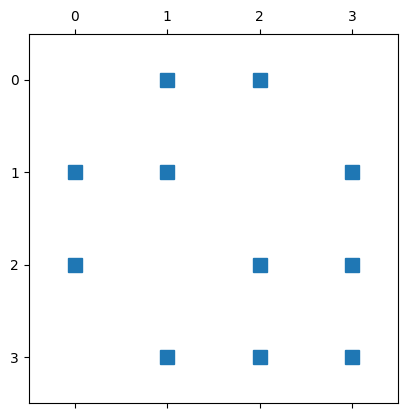

In [7]:
plt.spy(hamiltonian.to_sparse_matrix())

### Matrix Formulation

We can also convert the Hamiltonian `QubitPauliOperator` representation to a dense matrix and extract the Hamiltonian matrix elements. This transformation caters to computational tasks and subsequent quantum simulations.

In [8]:
hm = hamiltonian.to_sparse_matrix(2).todense()
hm.real

matrix([[ 0. , -4. , -4. ,  0. ],
        [-4. ,  3. ,  0. , -2. ],
        [-4. ,  0. ,  3. , -2. ],
        [ 0. , -2. , -2. ,  4.5]])

### Time Evolution Operator

To simulate the time evolution of the quantum system, we compute the matrix exponential of the Hamiltonian matrix. This process represents how the quantum state evolves over a specific time interval. For instance, a factor like $0.1$ can be interpreted as a discrete time step in the system's evolution.

In our implementation, we use the `expm` function to calculate the matrix exponential of the Hamiltonian for a time step of $0.1$. The time evolution operator \( U(t) \) is expressed as:

$$
U(t) = e^{-i H t}
$$

For a time step of $0.1$, this operator becomes:

$$
U(0.1) = e^{-i H \times 0.1}
$$

This calculated operator, `exp_hm`, will then be applied to simulate the quantum state's evolution over the time step.

In [9]:
# Compute the matrix exponential of the Hamiltonian for the time step of 0.1
exp_hm = expm(-1j * hm * 0.1)
exp_hm

array([[ 0.84639558+0.0152074j ,  0.05508436+0.36836211j,
         0.05508436+0.36836211j, -0.07461882+0.01911594j],
       [ 0.05508436+0.36836211j,  0.8615547 -0.27351321j,
        -0.09378179+0.022007j  ,  0.06951527+0.17342834j],
       [ 0.05508436+0.36836211j, -0.09378179+0.022007j  ,
         0.8615547 -0.27351321j,  0.06951527+0.17342834j],
       [-0.07461882+0.01911594j,  0.06951527+0.17342834j,
         0.06951527+0.17342834j,  0.8648741 -0.41980935j]])

### Circuit Construction & Visualization

After calculating the time evolution operator, the next logical step is to integrate this operator into a quantum circuit. This allows for direct simulations or runs on quantum hardware or simulator. The `pytket` library provides tools to seamlessly achieve this. By wrapping our time evolution operator in a 2-qubit unitary box, we can then incorporate it into a quantum circuit, setting the stage for subsequent quantum simulations or analyses.

In [10]:
# Creating a 2-qubit unitary box that represents the time evolution operator:
from pytket.circuit import Unitary2qBox

u2box = Unitary2qBox(exp_hm)

# Initializing a 2-qubit circuit and embedding the time evolution operator into it:
circ = Circuit(2)
circ.add_unitary2qbox(u2box, 0, 1)

[Unitary2qBox q[0], q[1]; ]

Retrieving the unitary matrix representation of the quantum circuit:

In [11]:
circ.get_unitary()

array([[ 0.84639558+0.0152074j ,  0.05508436+0.36836211j,
         0.05508436+0.36836211j, -0.07461882+0.01911594j],
       [ 0.05508436+0.36836211j,  0.8615547 -0.27351321j,
        -0.09378179+0.022007j  ,  0.06951527+0.17342834j],
       [ 0.05508436+0.36836211j, -0.09378179+0.022007j  ,
         0.8615547 -0.27351321j,  0.06951527+0.17342834j],
       [-0.07461882+0.01911594j,  0.06951527+0.17342834j,
         0.06951527+0.17342834j,  0.8648741 -0.41980935j]])

And obtaining the resulting quantum state after applying the circuit (from a default initial state):

In [12]:
circ.get_statevector()

array([ 0.84639558+0.0152074j ,  0.05508436+0.36836211j,
        0.05508436+0.36836211j, -0.07461882+0.01911594j])

### Decomposition

Recognizing the constraints of real quantum hardware, the constructed circuit is decomposed into a set of elementary gates, ensuring its adaptability and compatibility. Specifically, in quantum circuit design, 'boxed' operations encapsulate complex actions. To standardize our circuit for broader applications, we'll replace these boxed operations with sequences of elementary gates using pytket's `DecomposeBoxes`.

In [13]:
# Importing the necessary tool for gate decomposition:
from pytket.passes import DecomposeBoxes

# Decomposing custom gates in the circuit to ensure compatibility with quantum hardware:
DecomposeBoxes().apply(circ)

True

We can also visualize the quantum circuit using `pytket`'s rendering tool for Jupyter:

In [14]:
from pytket.circuit.display import render_circuit_jupyter

render_circuit_jupyter(circ)

### Gate Analysis

The quantum circuit, post-decomposition, is dissected to provide a breakdown of its comprising gate types. This analysis gives valuable insights into the circuit's intricacy and underlying structure.

Insights into the composition and complexity of our circuit can be obtained with the following command:

In [15]:
gate_counts(circ)

Counter({<OpType.TK1: 40>: 4,
         <OpType.X: 23>: 2,
         <OpType.Z: 22>: 2,
         <OpType.Y: 24>: 2,
         <OpType.TK2: 41>: 1})

The breakdown of gate occurrences in our quantum circuit is as follows:

- TK1 gates: 4
- X gates: 2
- TK2 gates: 1
- Z gates: 2
- Y gates: 2

This summary serve as a valuable reference when we delve into the topics of recompilation and optimization for execution on H-series devices.

*Note:* See [pytket.circuit.OpType](https://cqcl.github.io/tket/pytket/api/optype.html#pytket-circuit-optype) for the mathematical descriptions of TK1 and TK2 gates.

### Time evolution circuits

The given Hamiltonian, $-i H t$, needs to be discretized for simulation on a quantum computer. This is where the Trotter-Suzuki approximation comes in handy, allowing us to approximate the time evolution operator $e^{-i H t}$.

$$
e^{-i H t}=e^{-i\left(\frac{3}{8}\left(7-3 Z_0-Z_0 Z_1-3 Z_1\right)-\frac{x}{2}\left(3+Z_1\right) X_0-\frac{x}{2}\left(3+Z_0\right) X_1\right) t}
$$

### First-Order Trotter Step

In the first-order Trotter step, the time evolution operator is approximated by 
$
\left(\prod_j e^{-i H_j \delta t} \right)^{N_t}
$
where $\delta t = \frac{t}{N_t}$. Here, $ N_t $ represents the number of Trotter steps, which is a parameter that determines the granularity of the time evolution approximation. A higher value of $ N_t $ leads to a finer approximation of the time evolution operator.


In [16]:
# Setting the maximum time for the simulation
t_max = 1

# Defining the number of Trotter steps for the approximation
n_trotter_steps = 10

# Calculating the time step for each Trotter step
time_step = t_max / n_trotter_steps

# Creating a time line from 0 to t_max with equal intervals for each Trotter step
time_line = np.linspace(0, t_max, n_trotter_steps + 1)

# Printing the calculated time step
print(f"Time step: {time_step}")

# Multiplying the Hamiltonian by the time step to get a slice of the Hamiltonian for each Trotter step
hamiltonian_slice = hamiltonian * time_step

Time step: 0.1


In [17]:
print(hamiltonian_slice)

{(): 0.262500000000000, (Zq[0]): -0.112500000000000, (Zq[0], Zq[1]): -0.0375000000000000, (Zq[1]): -0.112500000000000, (Xq[0]): -0.300000000000000, (Xq[0], Zq[1]): -0.100000000000000, (Xq[1]): -0.300000000000000, (Zq[0], Xq[1]): -0.100000000000000}


After slicing the Hamiltonian with the calculated `time_step`, we convert the `hamiltonian_slice` into a matrix format. This is done by first converting the Hamiltonian slice into a sparse matrix representation and then converting it to a dense matrix. The `.real` part extracts the real component of the matrix, which is necessary for some quantum computing simulations and visualizations.

In [18]:
hamiltonian_slice.to_sparse_matrix().todense().real

matrix([[ 1.38777878e-17, -4.00000000e-01, -4.00000000e-01,
          0.00000000e+00],
        [-4.00000000e-01,  3.00000000e-01,  0.00000000e+00,
         -2.00000000e-01],
        [-4.00000000e-01,  0.00000000e+00,  3.00000000e-01,
         -2.00000000e-01],
        [ 0.00000000e+00, -2.00000000e-01, -2.00000000e-01,
          4.50000000e-01]])

### Constructing the Quantum Circuit for a Single Trotter Step

After calculating the Hamiltonian slice for a single time step, we proceed to construct the quantum circuit that simulates this evolution. We use a utility `gen_term_sequence_circuit` which builds a circuit for us starting from the Hamiltonian we want in the exponent of a single Trotter step, and the initial reference state we want to start from. [Documentation page](https://cqcl.github.io/tket/pytket/api/utils.html#pytket.utils.gen_term_sequence_circuit)


In [20]:
# initializing a quantum circuit with two qubits
initial_state = Circuit(2)

# generate the circuit for the Trotter step
trotter_step_circ = gen_term_sequence_circuit(hamiltonian_slice, initial_state)

# visualize the circuit
render_circuit_jupyter(trotter_step_circ)

The circuit for a single Trotter step is composed of several `CircBox` components. The `get_commands()` method is used to explore the composition of the circuit.

In [21]:
trotter_step_circ.get_commands()

[CircBox q[0], q[1];, CircBox q[0], q[1];, CircBox q[0], q[1];]

Each `CircBox` can be examined to reveal its internal structure, which typically consists of `PauliExpBox` boxes. We can get the individual `PauliExpBox` boxes from each `CircBox` in the circuit

In [22]:
pauliexpbox0 = trotter_step_circ.get_commands()[0].op
box_circ = pauliexpbox0.get_circuit()
box_circ.get_commands()

[PauliExpBox q[0];, PauliExpBox q[0], q[1];, PauliExpBox q[1];]

In this nested `CircBox`  there are 3 `PauliExpBox`, of which only one acts on 2 qubits

In [23]:
pauli_exp_box = box_circ.get_commands()[1].op

render_circuit_jupyter(pauli_exp_box.get_circuit())

For a more detailed analysis, we use the `DecomposeBoxes` pass from `pytket.passes`. This pass decomposes the circuit into fundamental quantum gates, allowing us to see the basic operations that constitute the Trotter step.

For one Trotter step: 

In [24]:
test_circuit = trotter_step_circ.copy()
DecomposeBoxes().apply(test_circuit)
render_circuit_jupyter(test_circuit)

and we can count the total number of gates

In [25]:
gate_counts(test_circuit)

Counter({<OpType.H: 33>: 8, <OpType.Rz: 36>: 7, <OpType.CX: 42>: 6})

or look at specific statistics of the circuit

In [26]:
print(f"Number of gates = {test_circuit.n_gates}")
print(f"Circuit depth = {test_circuit.depth()}")
print(f"Number of CX gates = {test_circuit.n_gates_of_type(OpType.CX)}")

Number of gates = 21
Circuit depth = 19
Number of CX gates = 6


## Example 1: Noiseless emulation of a circuit for one Trotter step

We will first run a noiseless statevector emulation of the circuit on Quantinuum's System Model H1 emulator. Quantinuum H-Series emulators model the physical and noise parameters of H-Series quantum computers. The emulators provide a way to turn the noise model off, while still modeling the physical properties of the device, such as ion transport. 

In [27]:
from pytket.extensions.quantinuum import QuantinuumBackend

h_backend = QuantinuumBackend("H1-2E")  # emulator

h_backend.login()

The device status can be checked using `device_state`.

In [28]:
h_backend.device_state(device_name="H1-2E")

'online'

#### One Trotter step

The Trotter step circuit can be enclosed in a `CircBox` and added to any circuit (this way we can add many steps in a sequence).

In [29]:
trotter_step_box = CircBox(trotter_step_circ)

# define circuit for one Trotter step
circ = Circuit(2)
circ.add_gate(trotter_step_box, circ.qubits)

render_circuit_jupyter(circ)

When we compile the circuit for the backend, the `CircBox` nested boxes get decomposed into native gates. Each backend in `pytket` has a list of default _passes_ that are applied to it. They can be applied by calling `backend.get_compiled_circuit()` with different `optimisation_level` arguments ([here](https://cqcl.github.io/pytket-quantinuum/api/index.html#default-compilation) some default values). Here we use the default `optimisation_level` for the `QuantinuumBackend`, which is 2.

*Note:* The measurement operations from the `MeasurementSetup` object are appended to the numerical circuit. Once this step is complete, the circuit is ready for submission.

In [30]:
circ_compiled = h_backend.get_compiled_circuit(circ.measure_all())

render_circuit_jupyter(circ_compiled)

Before submitting to the emulator, the total cost of running the set of circuits in H-System Quantum Credits (HQCs) can be checked beforehand.

In [31]:
n_shots = 100
cost = h_backend.cost(circ_compiled, n_shots=n_shots, syntax_checker="H1-2SC")
print("Cost of experiment in HQCs:", cost)

Cost of experiment in HQCs: 5.92


We submit the circuit to the Quantinuum H1-2 Emulator and make the emulation noiseless by passing the option `noisy_simulation=False`.

In [32]:
handle = h_backend.process_circuit(
    circ_compiled, n_shots=n_shots, noisy_simulation=False
)

In [34]:
circuit_status = h_backend.circuit_status(handle)
print(circuit_status)

StatusEnum.COMPLETED


In [35]:
result = h_backend.get_result(handle)
result.get_counts()

Counter({(0, 0): 39, (1, 0): 35, (0, 1): 24, (1, 1): 2})

### Example 2: Noisy emulation on the System Model H1 Emulator for two Trotter steps

Next we implement and run two Trotter steps on the H1-2E emulator with the emulator's default noise model for two Trotter steps. The noise model mimicks the noise of the H1-2 quantum computer.

Let's add two trotter steps to our circuit:

In [36]:
# two steps
circ = Circuit(2)
circ.add_gate(trotter_step_box, circ.qubits)
circ.add_gate(trotter_step_box, circ.qubits)

[CircBox q[0], q[1]; CircBox q[0], q[1]; ]

In [37]:
circ_compiled = h_backend.get_compiled_circuit(circ.measure_all())

In [38]:
print(
    f"Our circuit has {circ_compiled.n_gates} quantum gates in total and an overall depth of {circ_compiled.depth()}."
)
print(
    f"Of these gates {circ_compiled.n_gates_of_type(OpType.ZZPhase)} are two qubit gate, ZZPhase, counts."
)

Our circuit has 13 quantum gates in total and an overall depth of 8.
Of these gates 3 are two qubit gate, ZZPhase, counts.


In [39]:
render_circuit_jupyter(circ_compiled)

Before submitting to the emulator, the total cost of running the set of circuits in H-System Quantum Credits (HQCs) is checked beforehand.

In [40]:
n_shots = 100
cost = h_backend.cost(circ_compiled, n_shots=n_shots, syntax_checker="H1-2SC")
print("Cost of experiment in HQCs:", cost)

Cost of experiment in HQCs: 6.16


Now we run the circuits.

In [41]:
handle = h_backend.process_circuit(circ_compiled, n_shots=n_shots)

The status of the jobs can be checked with `ciruit_status` method. This method requires the `ResultHandle` to be passed as input. In this example, the job has completed and the results are reported as being ready to request.

In [43]:
circuit_status = h_backend.circuit_status(handle)
print(circuit_status.status)

StatusEnum.COMPLETED


Once a job's status returns completed, results can be returned using the `get_result` function in conjunction with the `get_counts` call.

In [44]:
result = h_backend.get_result(handle)
result.get_counts()

Counter({(1, 0): 47, (1, 1): 31, (0, 1): 19, (0, 0): 3})

We note that when using `optimisation_level`equal to 0, we compile to the native gates of the H-Series without optimization and the number of single and two-qubit gates is significantly larger than compared to the default `optimisation_level` of 2.

In [45]:
circ_compiled_0 = h_backend.get_compiled_circuit(circ, optimisation_level=0)
gate_counts(circ_compiled_0)

Counter({<OpType.Rz: 36>: 78,
         <OpType.PhasedX: 68>: 40,
         <OpType.ZZPhase: 73>: 12,
         <OpType.Measure: 63>: 2})

## Example 3: Symbolic Manipulation in Quantum Circuit Simulation

In this section, we explore the use of symbolic manipulation for quantum circuit simulation, particularly focusing on the Trotter-Suzuki decomposition. We employ `sympy` for defining symbolic variables, which represent key parameters like coupling strengths and time steps in our quantum system. These symbols allow us to dynamically adjust our circuit parameters.

The symbols are related to the coupling and the time step.

In [46]:
from sympy import symbols

syms = symbols("x dt")

We define various `QubitPauliString` objects to represent different Pauli operators acting on our qubits. 

In [47]:
zi = QubitPauliString([Qubit(0)], [Pauli.Z])
iz = QubitPauliString([Qubit(1)], [Pauli.Z])

xi = QubitPauliString([Qubit(0)], [Pauli.X])
ix = QubitPauliString([Qubit(1)], [Pauli.X])

zz = QubitPauliString([Qubit(0), Qubit(1)], [Pauli.Z, Pauli.Z])
xz = QubitPauliString([Qubit(0), Qubit(1)], [Pauli.X, Pauli.Z])
zx = QubitPauliString([Qubit(0), Qubit(1)], [Pauli.Z, Pauli.X])

Next, we define two dictionaries, `singles_syms` and `doubles_sym`, to represent parts of our Hamiltonian symbolically:

- `singles_syms`: Maps single-qubit Pauli strings to their coefficients. These terms, involving `Z` and `X` Pauli operators on individual qubits, reflect the linear contributions in the Hamiltonian. For example, terms like `zi` and `xi` are mapped to symbolic expressions involving `dt` and `x`, representing time step and coupling constants, respectively.

- `doubles_sym`: Represents two-qubit interaction terms. Here, combinations of `Z` and `X` operators on pairs of qubits are mapped to their corresponding coefficients. These terms capture the inter-qubit interactions in the Hamiltonian, with coefficients also expressed as functions of `dt` and `x`.

In [48]:
singles_syms = {
    zi: -21 / 8 * syms[1],
    iz: -21 / 8 * syms[1],
    xi: -3 / 2 * syms[0] * syms[1],
    ix: -3 / 2 * syms[0] * syms[1],
}

In [49]:
doubles_sym = {
    zz: -3 / 8 * syms[1],
    xz: -1 / 2 * syms[0] * syms[1],
    zx: -1 / 2 * syms[0] * syms[1],
}

We now combine the single-qubit and two-qubit interaction terms defined in `singles_syms` and `doubles_sym` to form the first-order Trotterized Hamiltonian:

In [50]:
hamiltonian_trotterized = QubitPauliOperator({**singles_syms, **doubles_sym})

In [51]:
hamiltonian_trotterized

{(Zq[0]): -2.625*dt, (Zq[1]): -2.625*dt, (Xq[0]): -1.5*dt*x, (Xq[1]): -1.5*dt*x, (Zq[0], Zq[1]): -0.375*dt, (Xq[0], Zq[1]): -0.5*dt*x, (Zq[0], Xq[1]): -0.5*dt*x}

We can generate the circuit by using the same function as before

In [52]:
circ = Circuit(2)
trotter_step_circ_symb = gen_term_sequence_circuit(hamiltonian_trotterized, circ)

In [53]:
render_circuit_jupyter(trotter_step_circ_symb)

Again, we can also decompose this symbolic circuit into basic gates and count these gates.

In [54]:
from pytket.passes import DecomposeBoxes

test_circuit = trotter_step_circ_symb.copy()
DecomposeBoxes().apply(test_circuit)
gate_counts(test_circuit)

Counter({<OpType.H: 33>: 8, <OpType.Rz: 36>: 7, <OpType.CX: 42>: 6})

In [55]:
render_circuit_jupyter(test_circuit)

We can also make this symbolic circuit into a box that we can repeat for multiple Trotter steps:

In [56]:
trotter_step_box_symb = CircBox(trotter_step_circ_symb)

This is a 2-step Trotter symbolic circuit:

In [57]:
# two steps
circ = Circuit(2)
circ.add_gate(trotter_step_box_symb, circ.qubits)
circ.add_gate(trotter_step_box_symb, circ.qubits)

[CircBox q[0], q[1]; CircBox q[0], q[1]; ]

In the final step of working with the symbolic circuit, we demonstrate how to substitute our symbolic parameters with actual numerical values:

1. **Defining Symbol Values**: We first define a list `x_dt_values` containing the specific values for our symbols. In this example, `x` is set to 2.0 and `dt` to 0.01.

2. **Creating the Symbol-Value Map**: Using `zip(syms, x_dt_values)`, we pair each symbol with its corresponding value, and then convert this pairing into a dictionary `sym_map`. This dictionary maps each symbolic variable to its numerical value.

3. **Applying Substitutions**: We use `circ.symbol_substitution(sym_map)` to apply these substitutions to our circuit. This method replaces each occurrence of the symbolic variables in `circ` with their defined numerical values.

Lastly, we render the updated circuit using `render_circuit_jupyter(circ)`. This visualization shows the circuit as it would be with the specific parameters applied.


In [58]:
x_dt_values = [2.0, 0.01]
sym_map = dict(zip(syms, x_dt_values))

In [59]:
sym_map

{x: 2.0, dt: 0.01}

In [60]:
circ.symbol_substitution(sym_map)
render_circuit_jupyter(circ)

## Implementation of the SU(2) 5-Plaquette Model Hamiltonian

Having explored the SU(2) 2-Plaquette Model, a foundational representation in lattice gauge theories, we now shift our focus to the more complex SU(2) 5-Plaquette Model. This transition marks a significant step towards understanding and simulating more intricate quantum systems. The 5-Plaquette Model, with its increased number of qubits, provides a richer and more detailed canvas to examine the dynamics of lattice gauge theories. This model's Hamiltonian, characterized by its division into electric and magnetic components, captures the nuanced interactions within a lattice. Such a detailed representation is crucial for simulating real-world quantum phenomena and lays the groundwork for advanced quantum computing applications. By delving into the 5-Plaquette Model, we gain deeper insights into the behavior of complex quantum systems, paving the way for more accurate simulations and potentially groundbreaking discoveries in the realm of quantum physics. The following section presents the Hamiltonian of the SU(2) 5-Plaquette Model, implemented using [`Qiskit`](https://qiskit.org), demonstrating how to interact with `Qiskit` code.

For the SU(2) 5-Plaquette Model, the 5-qubit Hamilatonian is given as follows

$$
\begin{aligned}
H= & \frac{g^2}{2}\left(h_E+h_B\right) \\
h_E= & \frac{3}{8}(3 N+1)-\frac{9}{8}\left(Z_0+Z_{N-1}\right)-\frac{3}{4} \sum_{n=1}^{N-2} Z_n \\
& -\frac{3}{8} \sum_{n=0}^{N-2} Z_n Z_{n+1} \\
h_B= & -\frac{x}{2}\left(3+Z_1\right) X_0-\frac{x}{2}\left(3+Z_{N-2}\right) X_{N-1} \\
& -\frac{x}{8} \sum_{n=1}^{N-2}\left(9+3 Z_{n-1}+3 Z_{n+1}+Z_{n-1} Z_{n+1}\right) X_n
\end{aligned}
$$

This model's Hamiltonian is explicitly broken down into electric $h_E $ and magnetic $h_B $ components, each comprising various terms involving Pauli $ \sigma_Z $ and $ \sigma_X $ operators.


In this section, we construct the Hamiltonian for our quantum system using Qiskit's `SparsePauliOp` build from a list of `Pauli` strings and their associated coefficients. The Hamiltonian is divided into two main components: the electric component (`h_e`) and the magnetic component (`h_b`). Each component is expressed as list of Pauli terms acting on the qubits and their respective coefficients. We use `SparsePauliOp` to write the Hamiltonian operator following the equations above quite literally (fix $x=2$):

- The electric component `h_e` includes terms involving `Z` Pauli operators, reflecting the electric interactions in the system.
- The magnetic component `h_b` comprises terms with `X` and combined `XZ` Pauli operators, representing the magnetic interactions.

The coefficients of each term are specific to our model, reflecting the strength of each interaction. We then combine these two components to form the complete Hamiltonian of the system, which is used for further analysis and simulation.

In [61]:
from qiskit.quantum_info import SparsePauliOp

h_e = [
    ("ZIIII", -9.0 / 8),
    ("IIIIZ", -9.0 / 8),
    ("IZIII", -3.0 / 4),
    ("IIZII", -3.0 / 4),
    ("IIIZI", -3.0 / 4),
    ("ZZIII", -3.0 / 8),
    ("IZZII", -3.0 / 8),
    ("IIZZI", -3.0 / 8),
    ("IIIZZ", -3.0 / 8),
]

h_b = [
    ("XIIII", -3.0),
    ("XZIII", -1.0),
    ("IIIIX", -3.0),
    ("IIIZX", -1.0),
    ("IXIII", -9.0 / 4),
    ("ZXIII", -3.0 / 4),
    ("IXZII", -3.0 / 4),
    ("ZXZII", -1.0 / 4),
    ("IIXII", -9.0 / 4),
    ("IZXII", -3.0 / 4),
    ("IIXZI", -3.0 / 4),
    ("IZXZI", -1.0 / 4),
    ("IIIXI", -9.0 / 4),
    ("IIZXI", -3.0 / 4),
    ("IIIXZ", -3.0 / 4),
    ("IIZXZ", -1.0 / 4),
]

hamiltonian = SparsePauliOp.from_list(h_e + h_b)

hamiltonian

SparsePauliOp(['ZIIII', 'IIIIZ', 'IZIII', 'IIZII', 'IIIZI', 'ZZIII', 'IZZII', 'IIZZI', 'IIIZZ', 'XIIII', 'XZIII', 'IIIIX', 'IIIZX', 'IXIII', 'ZXIII', 'IXZII', 'ZXZII', 'IIXII', 'IZXII', 'IIXZI', 'IZXZI', 'IIIXI', 'IIZXI', 'IIIXZ', 'IIZXZ'],
              coeffs=[-1.125+0.j, -1.125+0.j, -0.75 +0.j, -0.75 +0.j, -0.75 +0.j, -0.375+0.j,
 -0.375+0.j, -0.375+0.j, -0.375+0.j, -3.   +0.j, -1.   +0.j, -3.   +0.j,
 -1.   +0.j, -2.25 +0.j, -0.75 +0.j, -0.75 +0.j, -0.25 +0.j, -2.25 +0.j,
 -0.75 +0.j, -0.75 +0.j, -0.25 +0.j, -2.25 +0.j, -0.75 +0.j, -0.75 +0.j,
 -0.25 +0.j])

A dense (or sparse) matrix representation of the operator can be accessed directly with the method `SparsePauliOp.to_matrix()`:

In [62]:
hamiltonian.to_matrix(sparse=False)

array([[-6. +0.j, -4. +0.j, -4. +0.j, ..., -0. +0.j, -0. +0.j, -0. +0.j],
       [-4. +0.j, -3. +0.j, -0. +0.j, ..., -0. +0.j, -0. +0.j, -0. +0.j],
       [-4. +0.j, -0. +0.j, -3. +0.j, ..., -0. +0.j, -0. +0.j, -0. +0.j],
       ...,
       [-0. +0.j, -0. +0.j, -0. +0.j, ...,  3. +0.j, -0. +0.j, -1. +0.j],
       [-0. +0.j, -0. +0.j, -0. +0.j, ..., -0. +0.j,  1.5+0.j, -2. +0.j],
       [-0. +0.j, -0. +0.j, -0. +0.j, ..., -1. +0.j, -2. +0.j,  3. +0.j]])

As a first step we can compute the ground state of the Hamiltonian by diagonalizing and extracting the lowest eigenvalue. There are many ways to do this but one can pass the (sparse) matrix obtained from `SparsePauliOp` representing our Hamiltonian to a numerical eigensolver

In [63]:
from scipy.sparse.linalg import eigs

vals, vecs = eigs(hamiltonian.to_matrix(sparse=True), k=1)
print(f"Energy of the ground state {vals[0].real}")

Energy of the ground state -16.999769538608106


In this section, we build utility functions to translate `Qiskit`'s Hamiltonian representation into the `QubitPauliOperator` format used by `pytket`. 

- `qps_from_sparsepauliop`: This function converts a tensor of Pauli operators from `SparsePauliOp` format to pytket's `QubitPauliString`. It iterates over qubit indices and corresponding Pauli operators, mapping them to the `pytket` equivalent.

- `qpo_from_sparsepauliop`: This function takes an `Qiskit` `SparsePauliOp` and converts it into a `QubitPauliOperator`. It processes each term in the `Qiskit` operator, using `qps_from_sparsepauliop` for conversion, and associates it with the corresponding coefficient.

Finally, we apply `qpo_from_sparsepauliop` to our previously defined Hamiltonian and print the result. This step confirms that the Hamiltonian is correctly converted into the format required by pytket for further quantum computations.

In [64]:
from pytket.pauli import Pauli, QubitPauliString
from pytket.utils import QubitPauliOperator
from pytket import Qubit
from collections import defaultdict

pauli_sym = {"I": Pauli.I, "X": Pauli.X, "Y": Pauli.Y, "Z": Pauli.Z}


def qps_from_sparsepauliop(paulis):
    """Convert SparsePauliOp tensor of Paulis to pytket QubitPauliString."""
    qlist = []
    plist = []
    for q, p in enumerate(paulis):
        if p != "I":
            qlist.append(Qubit(q))
            plist.append(pauli_sym[p])
    return QubitPauliString(qlist, plist)


def qpo_from_sparsepauliop(sp_op):
    """Convert SparsePauliOp QubitOperator to pytket QubitPauliOperator."""
    tk_op = defaultdict(complex)
    for term, coeff in sp_op.to_list():
        string = qps_from_sparsepauliop(term)
        tk_op[string] += coeff
    return QubitPauliOperator(tk_op)


hamiltonian_op = qpo_from_sparsepauliop(hamiltonian)
print(hamiltonian_op)

{(Zq[0]): -1.12500000000000, (Zq[4]): -1.12500000000000, (Zq[1]): -0.750000000000000, (Zq[2]): -0.750000000000000, (Zq[3]): -0.750000000000000, (Zq[0], Zq[1]): -0.375000000000000, (Zq[1], Zq[2]): -0.375000000000000, (Zq[2], Zq[3]): -0.375000000000000, (Zq[3], Zq[4]): -0.375000000000000, (Xq[0]): -3.00000000000000, (Xq[0], Zq[1]): -1.00000000000000, (Xq[4]): -3.00000000000000, (Zq[3], Xq[4]): -1.00000000000000, (Xq[1]): -2.25000000000000, (Zq[0], Xq[1]): -0.750000000000000, (Xq[1], Zq[2]): -0.750000000000000, (Zq[0], Xq[1], Zq[2]): -0.250000000000000, (Xq[2]): -2.25000000000000, (Zq[1], Xq[2]): -0.750000000000000, (Xq[2], Zq[3]): -0.750000000000000, (Zq[1], Xq[2], Zq[3]): -0.250000000000000, (Xq[3]): -2.25000000000000, (Zq[2], Xq[3]): -0.750000000000000, (Xq[3], Zq[4]): -0.750000000000000, (Zq[2], Xq[3], Zq[4]): -0.250000000000000}


The next line of code converts the `QubitPauliOperator` representation of the Hamiltonian, obtained in the previous step, into a dense matrix format. The `to_sparse_matrix()` method first transforms the Hamiltonian into a sparse matrix. We then use `todense()` to convert this sparse matrix into a regular, dense matrix. This dense matrix representation is useful for certain types of numerical analyses and visual inspections of the Hamiltonian structure.

In [65]:
hamiltonian_op.to_sparse_matrix().todense()

matrix([[-6. +0.j, -4. +0.j, -4. +0.j, ...,  0. +0.j,  0. +0.j,  0. +0.j],
        [-4. +0.j, -3. +0.j,  0. +0.j, ...,  0. +0.j,  0. +0.j,  0. +0.j],
        [-4. +0.j,  0. +0.j, -3. +0.j, ...,  0. +0.j,  0. +0.j,  0. +0.j],
        ...,
        [ 0. +0.j,  0. +0.j,  0. +0.j, ...,  3. +0.j,  0. +0.j, -1. +0.j],
        [ 0. +0.j,  0. +0.j,  0. +0.j, ...,  0. +0.j,  1.5+0.j, -2. +0.j],
        [ 0. +0.j,  0. +0.j,  0. +0.j, ..., -1. +0.j, -2. +0.j,  3. +0.j]])

In [66]:
np.allclose(
    hamiltonian_op.to_sparse_matrix().todense(), hamiltonian.to_matrix(sparse=False)
)

True

We now proceed with the Trotter-Suzuki decomposition to approximate the time-evolution operator of the Hamiltonian in quantum simulations as we did above.

*Note:* `rescaling_factor_from_pytket = np.pi/2` is defined for aligning simulation results with exact theoretical predictions. This factor compensates for an additional π/2 factor introduced by `gen_term_sequence_circuit` in `pytket`, which affects the time evolution steps. When comparing with exact results, divide the time step ($\delta t$) by this rescaling factor to account for this discrepancy.

In [67]:
# rescaling_factor_from_pytket = np.pi/2  ## use it to divide \deltat in case you want to compare with the exact results: gen_term_sequence adds Pauliexpbox with an extrat pi/2 factor
t_max = 1
n_trotter_steps = 10
time_step = t_max / n_trotter_steps
time_line = np.linspace(0, t_max, n_trotter_steps + 1)
print(f"Time step: {time_step}")

hamiltonian_slice = hamiltonian_op * time_step

Time step: 0.1


Next we construct the corresponding five-qubit circuit for two Trotter steps. A product of exponential of Pauli strings can be automatically generated by `pytket` using `gen_term_sequence_circuits`, including aggregating mutually commuting terms into groups. 

In [68]:
initial_state = Circuit(5)
trotter_step_circ = gen_term_sequence_circuit(hamiltonian_slice, initial_state)

The Trotter step circuit can be enclosed in a `CircBox` and added to any circuit (this way we can add many steps in a sequence)

In [69]:
trotter_step_box = CircBox(trotter_step_circ)

Now one Trotter step is a single box, and we can simply stack boxes to create circuits for more Trotter steps

In [70]:
# two steps
circ = Circuit(5)
circ.add_gate(trotter_step_box, circ.qubits)
circ.add_gate(trotter_step_box, circ.qubits)

[CircBox q[0], q[1], q[2], q[3], q[4]; CircBox q[0], q[1], q[2], q[3], q[4]; ]

In [71]:
from pytket.circuit.display import render_circuit_jupyter

render_circuit_jupyter(circ)

Now we sign into the Quantinuum Backend we will submit to, H1-2E, and compile the circuit for the backend.

In [66]:
from pytket.extensions.quantinuum import QuantinuumBackend

h_backend = QuantinuumBackend("H1-2E")  # emulator

h_backend.login()

In [72]:
circ_compiled = h_backend.get_compiled_circuit(circ.measure_all())
render_circuit_jupyter(circ_compiled)

We can look at the statistics of the circuit before running it on the emulator.

In [73]:
gate_counts(circ_compiled)

Counter({<OpType.PhasedX: 68>: 59,
         <OpType.ZZPhase: 73>: 34,
         <OpType.Measure: 63>: 5})

Now we run the circuit on the Quantinuum H1-2 Emulator. Before submitting to the emulator, the total cost of running the circuit should be checked beforehand.

In [74]:
n_shots = 100
cost = h_backend.cost(circ_compiled, n_shots=n_shots, syntax_checker="H1-2SC")
print("Cost of experiment in HQCs:", cost)

Cost of experiment in HQCs: 13.98


Now we run the circuit with the noise model turned on

In [75]:
handle = h_backend.process_circuit(
    circ_compiled, n_shots=n_shots, noisy_simulation=True
)

In [77]:
circuit_status = h_backend.circuit_status(handle)
print(circuit_status)

CircuitStatus(status=<StatusEnum.COMPLETED: 'Circuit has completed. Results are ready.'>, message='{"name": "job", "submit-date": "2024-01-11T06:24:50.716190", "result-date": "2024-01-11T06:25:15.622257", "queue-position": null, "cost": "13.98", "error": null}', error_detail=None, completed_time=None, queued_time=None, submitted_time=None, running_time=None, cancelled_time=None, error_time=None, queue_position=None)


In [78]:
result = h_backend.get_result(handle)
result.get_counts()

Counter({(1, 0, 1, 0, 1): 36,
         (1, 0, 1, 1, 0): 6,
         (1, 1, 1, 0, 1): 6,
         (0, 0, 0, 0, 1): 5,
         (0, 1, 1, 0, 1): 5,
         (1, 0, 1, 1, 1): 5,
         (0, 1, 1, 1, 1): 4,
         (1, 1, 0, 1, 0): 4,
         (1, 1, 0, 1, 1): 4,
         (0, 0, 1, 0, 1): 3,
         (0, 1, 0, 0, 1): 3,
         (1, 0, 1, 0, 0): 3,
         (1, 0, 0, 0, 0): 2,
         (1, 0, 0, 1, 0): 2,
         (1, 0, 0, 1, 1): 2,
         (1, 1, 0, 0, 0): 2,
         (0, 0, 0, 1, 0): 1,
         (0, 0, 0, 1, 1): 1,
         (0, 1, 0, 1, 1): 1,
         (0, 1, 1, 0, 0): 1,
         (1, 0, 0, 0, 1): 1,
         (1, 1, 0, 0, 1): 1,
         (1, 1, 1, 0, 0): 1,
         (1, 1, 1, 1, 1): 1})

We can also plot the result using the following helper code:

In [90]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt


def plot_counts(counts):
    counts_record = [
        {"State": str(state), "Count": count} for state, count in counts.items()
    ]
    count_df = pd.DataFrame().from_records(counts_record)
    sns.catplot(x="State", y="Count", kind="bar", data=count_df, aspect=12, height=2)
    plt.show()

In [91]:
counts = result.get_counts()

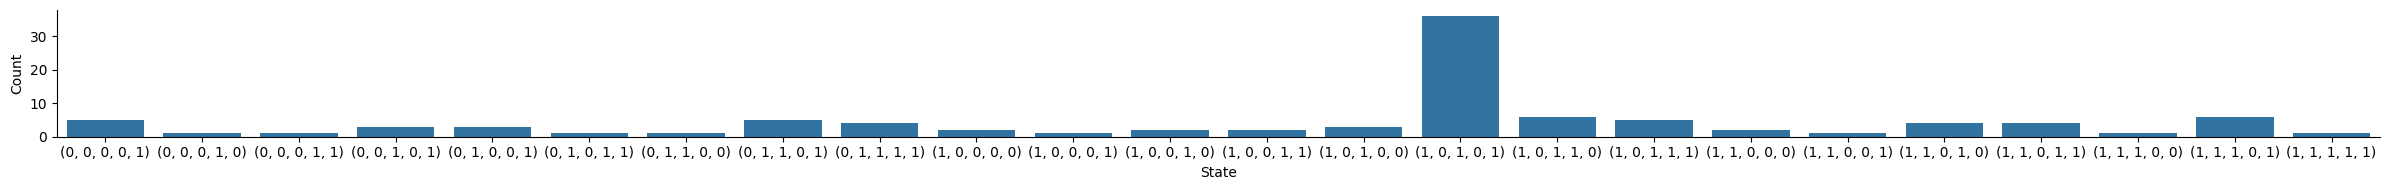

In [92]:
plot_counts(counts)

And compare our results to the noiseless emulation, we see that our emulator results match the noiseless simulation closely.

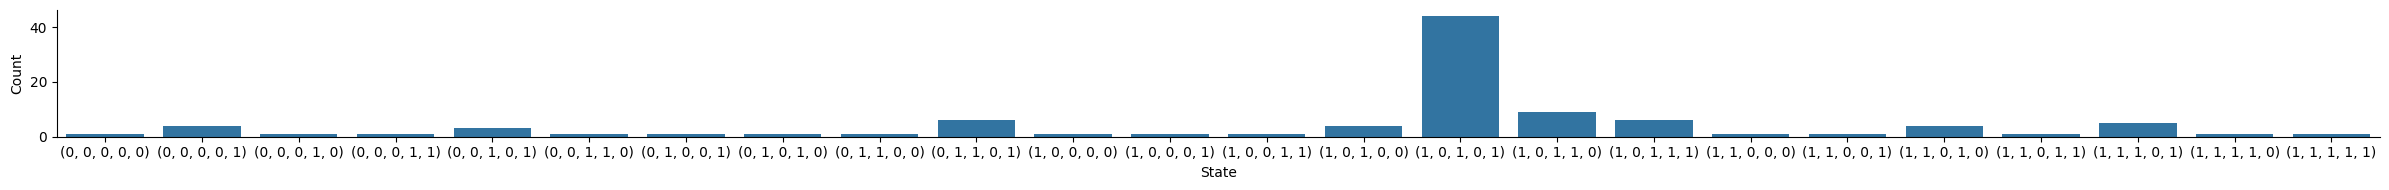

In [93]:
noiseless_handle = h_backend.process_circuit(
    circ_compiled, n_shots=n_shots, noisy_simulation=False
)
noiseless_result = h_backend.get_result(noiseless_handle)
noiseless_counts = noiseless_result.get_counts()
plot_counts(noiseless_counts)

One can also run the noiseless simulation using the Qiskit `Aer` backend directly from `pytket` using our `pytket-qiskit` extension:

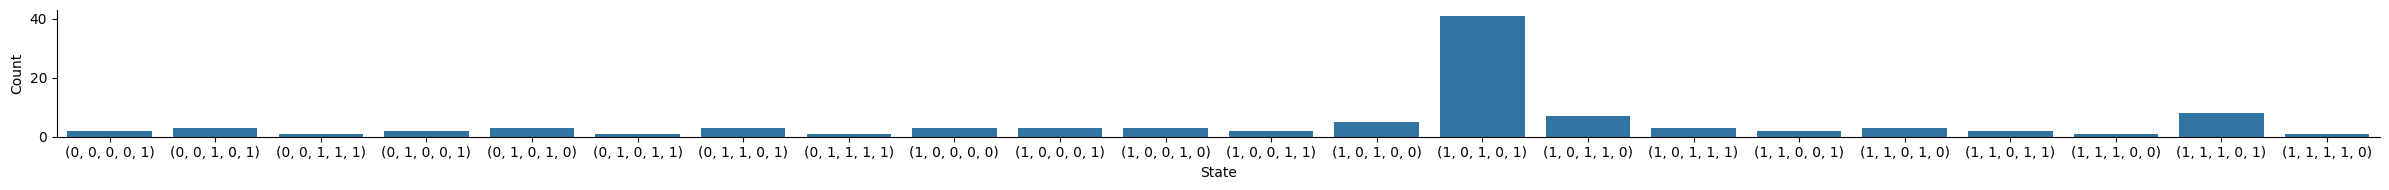

In [94]:
from pytket.extensions.qiskit import AerBackend

# define Aer backend
backend = AerBackend()
# compile circuit as usual, but now for the new backend
compiled_circ = backend.get_compiled_circuit(circ)

# submit and run the job: this runs locally and not in the cloud
handle = backend.process_circuit(compiled_circ, n_shots=100)
counts = backend.get_result(handle).get_counts()
plot_counts(counts)
# print(counts)

## Definitions

Definitions for the use case context in this article.

- *Quantum Field Theory (QFT):* a mathematical and conceuptual framework in theoretical physics extending quantum mechanics, which deals with particles, over to fields, which are systems with infinite number of degrees of freedom. It is used in particle physics to construct physical models of subatomic particles and condensed matter physics to construct models of quasiparticles. Difficult due to the infinite number of degrees of freedom.
- *Lattice Gauge Theory (LGT):* a mathematical framework in QFT. Rather than having infinite degrees of freedom, space and time are discretized to a very large number of degrees of freedom, enabling its study on computers. 
- *Perturbation Theory:* a method for finding an approximate solutions to a problem, by starting from the exact solution of a related, simpler problem
- *Quantum Chromodynamics:* theory that describes the action of the strong nuclear force, the fundamental interaction between subatomic particles of matter inside protons and neutrons.

<div align="center"> &copy; 2023 by Quantinuum. All Rights Reserved. </div>